# Прогноз оттока клиентов (телеком)

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Выгрузка и исследовательский анализ данных

In [1]:
# Необходимые библиотеки (по мере работы над проектом, будет дополняться)
!pip install -q phik

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import phik
import sklearn

from functools import reduce
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Функция посторения круговой диаграммы
def pie_plot (df, column, title, legend):
    df = df.groupby(column).size()
    df.plot(kind='pie', autopct='%1.1f%%', fontsize=14, cmap='Accent', labels=['','','',''], figsize=(6, 6))
    plt.title(title, fontsize=13)
    plt.ylabel('')
    plt.legend(legend, fontsize=13, loc='upper left', bbox_to_anchor=(0.9, 0.9))
    plt.show()

Последовательно изучим каждую из таблиц.

#### Tаблица `contract_new.csv` — информация о договоре

In [3]:
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_contract.info()
df_contract.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
#Приведем столбцы к змеиному регистру
df_contract = df_contract.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate':'end_date',
    'Type':'type',
    'PaperlessBilling':'paperless_billing',
    'PaymentMethod':'payment_method',
    'MonthlyCharges':'monthly_charges',
    'TotalCharges':'total_charges'}) 
print(df_contract.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [6]:
df_contract['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [7]:
df_contract['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Описание столбцов для таблицы `contract_new.csv`:
- `customer_id`: ID клиента
- `begin_date`: Дата заключения договора
- `end_date`: Дата окончания действия договора (`No`- договор еще действует)
- `type`: Тип договора (`Month-to-month`, `One year`, `Two year`)
- `paperless_billing`: Безбумажный автоматизированный процесс выставления счетов
- `payment_method`: Способ платы (`Electronic check`, `Mailed check`, `Bank transfer (automatic)`, `Credit card (automatic)`)
- `monthly_charges`: Ежемесячные платежи
- `total_charges`: Общие доходы от одного клиента

Следует изменить тип столбца:
- total_charges тип: float

In [8]:
print(df_contract.loc[df_contract['total_charges']==' '])

     customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check          

Информация по договорам актуальа на 1 февраля 2020 года. В этот же день было создано несколько новых договоров, оплата по которым еще не прошла. Это объясняет надичие нулевых зачений в столбце `total_charges`. Пропусков в этом столбце мало, их можно удалить.

In [9]:
print(df_contract.loc[df_contract['total_charges']==' ','total_charges'].count())

df_contract.drop(df_contract.loc[df_contract['total_charges'] == ' '].index, inplace=True)
df_contract.reset_index(drop=True, inplace=True)

df_contract['total_charges'] = df_contract['total_charges'].astype('float')
df_contract.head()

11


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


Проверим данные на наличие дубликатов и пропусков.

In [10]:
df_contract.duplicated().sum()

0

In [11]:
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [12]:
df_contract['customer_id'].duplicated().sum()

0

Ни пропусков ни дубликатов (в том числе дубликатов в столбце `customer_id`) не обнаружено.

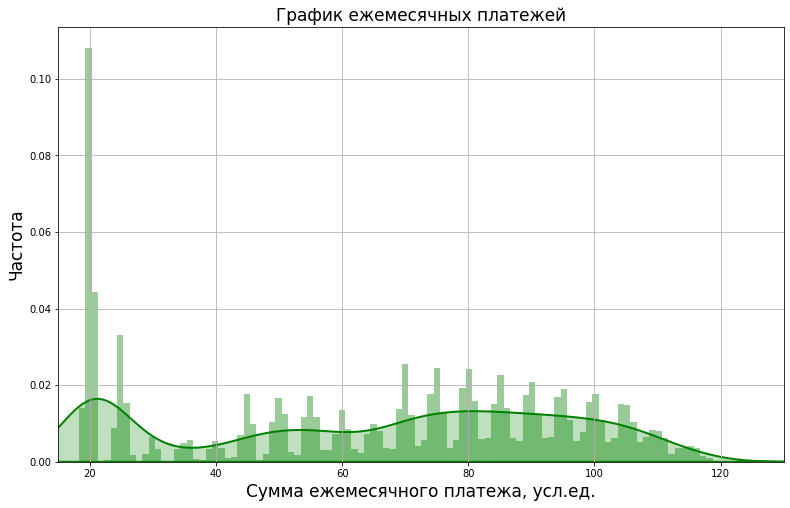

In [13]:
plt.figure(figsize=(13,8))

ax = sns.distplot(df_contract['monthly_charges'], hist = True, color='green', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График ежемесячных платежей', fontsize=17)
plt.grid(True)
plt.xlim([15, 130])
ax.set_xlabel('Сумма ежемесячного платежа, усл.ед.', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

Левый пик на графике свидетельствует о том, что многие платят ежемесячный минимум за услуги (скорее всего у них подключена одна-две наиболее их интересующие услуги). Также можно отметить пиковый характер графика. Вероятнее всего это связано с популярностью определенных наборов услуг (возможно они подключаются пакетами).

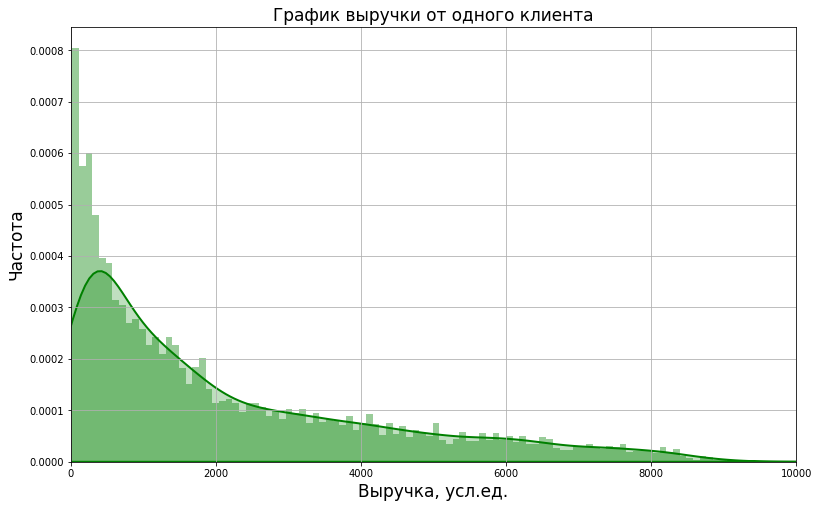

In [14]:
plt.figure(figsize=(13,8))

ax = sns.distplot(df_contract['total_charges'], label='', color='green', hist = True, bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График выручки от одного клиента', fontsize=17)
plt.grid(True)
plt.xlim([0, 10000])
ax.set_xlabel('Выручка, усл.ед.', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

График общих доходов от одного клиента имеет вид гиперболы, что вполне логично. Во первых, мало клиентов, которые оставались с оператором на протяжении многих лет, а во вторых, даже за длительное время значительная сумма не успела бы накопиься, если, например, клиент пользовался всего одной-двумя услугами. 

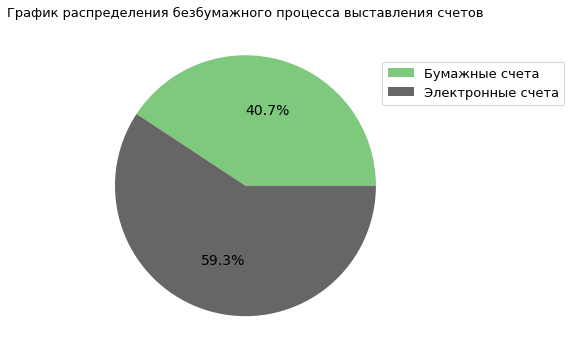

In [15]:
pie_plot(df_contract, 'paperless_billing', 
        'График распределения безбумажного процесса выставления счетов',
        ['Бумажные счета','Электронные счета'])

#### Tаблица `personal_new.csv` — персональные данные клиента

In [16]:
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_personal.info()
df_personal.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [17]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [18]:
#Приведем столбцы к змеиному регистру
df_personal = df_personal.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen'}) 
df_personal.columns = df_personal.columns.str.lower()
print(df_personal.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [19]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [20]:
df_personal['senior_citizen'].unique()

array([0, 1])

In [21]:
df_personal['partner'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
df_personal['dependents'].unique()

array(['No', 'Yes'], dtype=object)

Описание столбцов для таблицы `personal_new.csv`:
- `customer_id`: ID клиента
- `gender`: Пол клиента
- `senior_citizen`: Пенсионер 
- `partner`: Находится ли в браке
- `dependents`: Наличие иждивенцев

Изменим тип данных для столбца `senior_citizen`

In [23]:
df_personal.loc[df_personal['senior_citizen']==1,'senior_citizen'] = 'Yes'
df_personal.loc[df_personal['senior_citizen']==0,'senior_citizen'] = 'No'
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Проверим данные на наличие дубликатов и пропусков.

In [24]:
df_personal.duplicated().sum()

0

In [25]:
df_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [26]:
df_personal['customer_id'].duplicated().sum()

0

Пропусков и дубликатов не обнаружено.

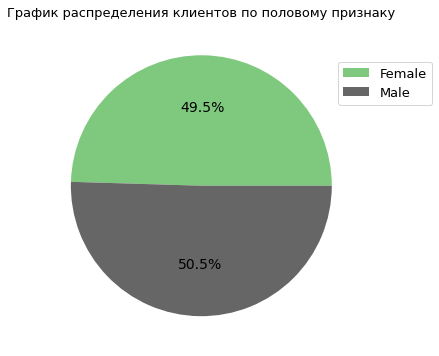

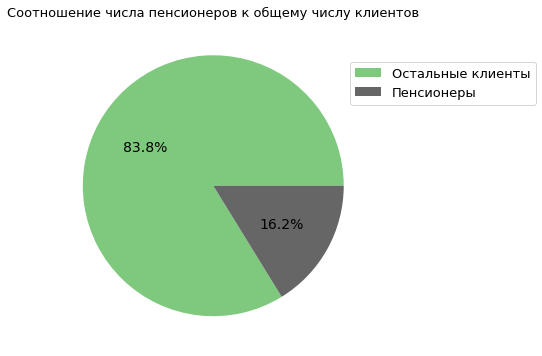

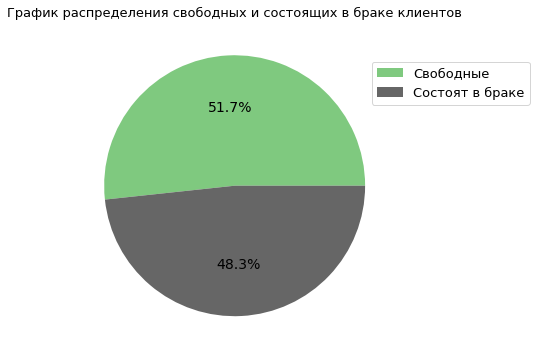

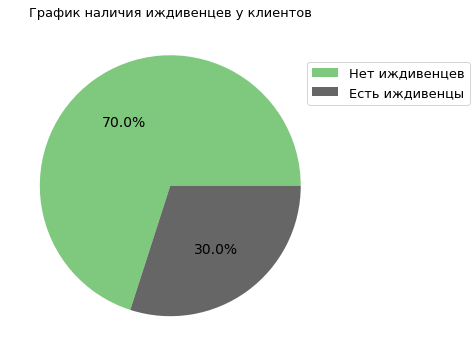

In [27]:
pie_plot(df_personal, 'gender', 
        'График распределения клиентов по половому признаку',
        ['Female','Male'])

pie_plot(df_personal, 'senior_citizen', 
        'Соотношение числа пенсионеров к общему числу клиентов',
        ['Остальные клиенты','Пенсионеры'])

pie_plot(df_personal, 'partner', 
        'График распределения свободных и состоящих в браке клиентов',
        ['Свободные','Состоят в браке'])

pie_plot(df_personal, 'dependents', 
        'График наличия иждивенцев у клиентов',
        ['Нет иждивенцев','Есть иждивенцы'])

По всем диаграммам, построенным выше можно сказать о разнообразии клиентной базы, что хорошо для обучения модели.

#### Tаблица `internet_new.csv` — информация об интернет-услугах

In [28]:
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_internet.info()
df_internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7873-CVMAW,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [29]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [30]:
#Приведем столбцы к змеиному регистру
df_internet = df_internet.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity':'online_security',
    'OnlineBackup':'online_backup',
    'DeviceProtection':'device_protection',
    'TechSupport':'tech_support',
    'StreamingTV':'streaming_tv',
    'StreamingMovies':'streaming_movies'}) 
print(df_internet.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [31]:
df_internet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Описание столбцов для таблицы `contract_new.csv`:
- `customer_id`: ID клиента
- `internet_service`: Тип подключения (`DSL`,`Fiber optic`)
- `online_security`: Онлайн-безопасность 
- `online_backup`: Онлайн резервное копирование
- `device_protection`: Защита устройства
- `tech_support`: Техническая поддержка
- `streaming_tv`: Стриминговое тв
- `streaming_movies`: Стриминговое кино

Проверим данные на наличие дубликатов и пропусков.

In [32]:
df_internet.duplicated().sum()

0

In [33]:
df_internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [34]:
df_internet['customer_id'].duplicated().sum()

0

Ни пропусков ни дубликатов не обнаружено.

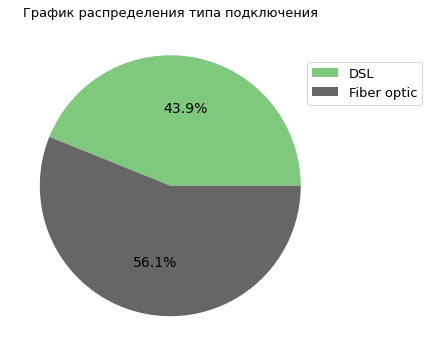

In [35]:
pie_plot(df_internet, 'internet_service', 
        'График распределения типа подключения',
        ['DSL','Fiber optic'])

#### Tаблица `phone_new.csv` — информация об услугах телефонии

In [36]:
df_phone = pd.read_csv('/datasets/phone_new.csv')
df_phone.info()
df_phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7873-CVMAW,No
freq,1,3390


In [37]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [38]:
#Приведем столбцы к змеиному регистру
df_phone = df_phone.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines'}) 
print(df_phone.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


Описание столбцов для таблицы `contract_new.csv`:
- `customer_id`: ID клиента
- `multiple_lines`: Наличие нескольких линий

Проверим данные на наличие дубликатов и пропусков.

In [39]:
df_phone.duplicated().sum()

0

In [40]:
df_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

In [41]:
df_phone['customer_id'].duplicated().sum()

0

Ни пропусков ни дубликатов не обнаружено.

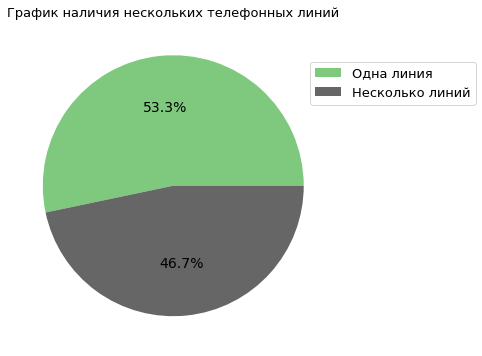

In [42]:
pie_plot(df_phone, 'multiple_lines', 
        'График наличия нескольких телефонных линий',
        ['Одна линия','Несколько линий'])

### План 

- Все таблицы можно объеденить в одну таблицу по ключу `customer_id`. Полученную таблицу нужно будет еще раз проверить на наличие пропусков, дубликатов, и аномалий так как не у всех клиентов может быть одновременно подключены стациоарная телефонная связь и интернет. Записей в таблицах `internet_new.csv` и `phone_new.csv` меньше, чем в таблице `contract_new.csv`, так как не все клиенты пользуются и телефонной связью и интернетом одновременно.
- Составить портрет клиента и уходящего клиента.
- Можно добавить несколько дополнительных признаков: как долго человек является клиентом
- Удалить ненужные признаки.
- В данных есть несколько количественных категорий. Категорий в каждой из них не очень много, поэтому для кодирования подойдет OHE (One-hot-encoding).
- Целевой признак - столбец `end_date`. Нужно проверить правильность этого столбца и исключить строки с аномальными значениями. Например, если даты в `begin_date` и `end_date` расположены не в хронологическом порядке. Также, может произойти ситуация, когда даты `begin_date` и `end_date` совпадают. В таком случае есть вероятность, что клиент случайно подключил услугу. Такого клиента нельзя считать ушедшим, потому что он и не приходил, однако уведомление о скидке может в этом случае приманить нового клиента.
- Задача классификации - будем использовать для обучения модель Логистической регрессии, Случайный лес и CatBoost.
- В качестве метрики используется ROC-AUC с предшествующей балансировкой классов.
- Для поиска нужных гиперпараметров модели будет использоваться gridsearch.

### Вопросы к заказчику

1) В таблице `contract_new.csv` в столбцах `total_charges` и `monthly_charges` не указаны единицы измерения. Можно было бы предположить, что сумма указана в рублях, однако цены за услги в 20-120 руб. ежемесячно выглядят странно (у любого существующего сегодня оператора цены в 3-5 раз выше). 
 - Вопрос: В каких единицах указаны данные о выручке и о ежемесячной оплате?

2) Указаны различные виды платных услуг (антивирус, тех.поддержка, облачное хранилище и т.д.), но нет данных о стоимости каждой из услуг. Возможно, некоторые из них бесплатны, и их подключение не влияет на отток клиентов. Такие услуги можно было бы исключить из данных для ускорения обучения модели. 
- Вопрос: Какая стоимость каждой из предоставленных услуг?

3) Оператор хочет выдавать промокоды и специальные условия тем, кто хочет уйти, но нет сведений о том есть ли среди уже имеющихся данных клиенты, которые пользуются промокодами, скидками или более выгодными пакетами, включающими в себя несколько услуг сразу. Клиенты уже имеющие выгодные условия будут реже уходить, и таким клиентам не стоит повторно выдавать скидки. Также, для бизнеса может быть опасно, если модель будет распознавать клиентов со скидками как собирающихся уходить, и будет давать им еще больше скидок и промокодов.
- Вопрос: Есть ли сведения о предоставлении скидок клиентам из базы данных?

4) Причиной ухода заказчика является неудовлетворенность предоставленными услугами. Но что если массовый отток клиентов произошел из-за неисправности сети. В таком случае, нужно не скидки клиентам выдавать, а чинить оборудование. Данные о месте жительства клиента (или информация о салоне связи, в котором заключался договор) помогли бы определить причину ухода точнее. Например, если клиенты уходят из определенного района - стоит проверить или установить новое более современное оборудование в этом районе. Если клиенты уходят из всех районов равномерно - оборудование в проядке.
- Вопрос: есть ли даннные о месте жительства клиента или информация о салоне связи, в котором заключался договор?

### Добавление новых признаков и анализ данных

Целевой признак - факт ухода клиента. Добавим столбец с логическим типом данных, где 1 - клиент ушел.

In [43]:
df_contract.loc[df_contract['end_date']=='No','end_contract'] = '0'
df_contract.loc[df_contract['end_date']!='No','end_contract'] = '1'
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   end_contract       7032 non-null   object 
dtypes: float64(2), object(7)
memory usage: 494.6+ KB


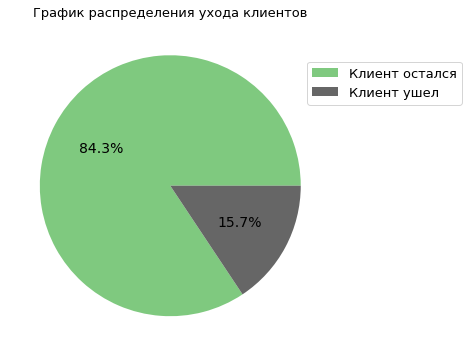

In [44]:
pie_plot(df_contract, 'end_contract', 
        'График распределения ухода клиентов',
        ['Клиент остался','Клиент ушел'])

Около 1/6 клиентов расторгло контракт. В данном случае мы имеем дело с дисбалансом классов.

Также, добавим новый признак - срок действия договора (как разность между датой заключения и датой окончания договора).

In [45]:
df_contract.loc[df_contract['end_date']=='No','end_date'] = '2020-02-01'

df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

df_contract['contract_time'] = ((df_contract['end_date'] - df_contract['begin_date']).dt.days)

df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   end_contract       7032 non-null   object        
 9   contract_time      7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 549.5+ KB


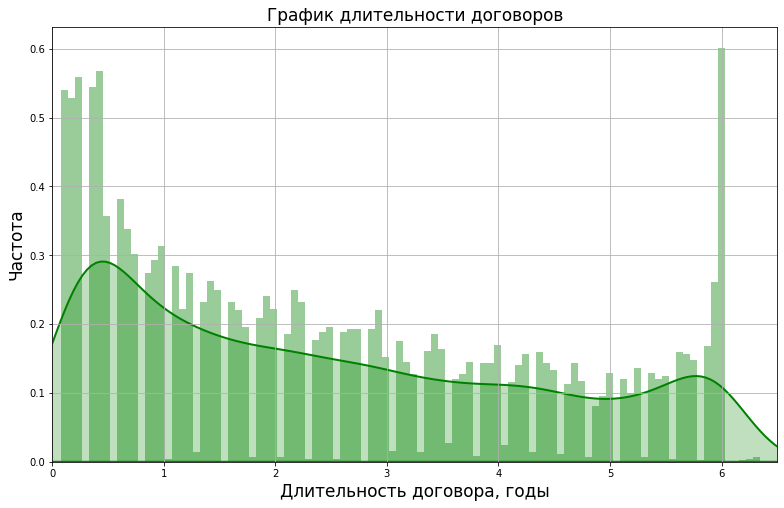

In [46]:
plt.figure(figsize=(13,8))

ax = sns.distplot(df_contract['contract_time']/365, hist = True, color='green', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График длительности договоров', fontsize=17)
plt.grid(True)
plt.xlim([0, 6.5])
ax.set_xlabel('Длительность договора, годы', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

Правый пик скорее всего свидетельствует о клиентах, которые все еще пользуются услугами оператора (вероятно данные предоставленны за последние 6 лет). Левый пик может свидетельствовать о 3-х возможных ситуациях: либо в течение последнего года была проведена неплохая рекламная компания и количество клиентов резко стало расти, либо услуги оператора не устраивают клиента, и они уходят после порвого же года, либо после окончания срока действия договора клиент заключает новый договор и получает новый id.

Изучим данные о договорах, длительность которых более 5.5 лет (правый пик).

In [47]:
print('Всего договоров длительностью более 5.5 лет: ',
      df_contract.loc[df_contract['contract_time']/365>5.5,'end_contract'].count())
print('Из них расторгнуто договоров: ', 
      df_contract.loc[df_contract['contract_time']/365>5.5,'end_contract'].astype(int).sum())

Всего договоров длительностью более 5.5 лет:  722
Из них расторгнуто договоров:  7


Клиенты со сроком действия договора более 5.5 лет (более 99%) продолжают пользоваться услугами оператора.

### Объединение таблиц и заполнение пропусков 

In [48]:
data =[df_contract, df_personal, df_internet, df_phone]
df = reduce(lambda left, right: pd.merge(left,right,on=['customer_id'], how='outer'), data)
df.drop(columns=['customer_id'], axis=1, inplace=True) #удаляем столбец, т.к. id не влияет на то, уйдет клиент или нет
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   end_contract       7032 non-null   object        
 8   contract_time      7032 non-null   float64       
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   object        
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

In [49]:
#Удаляем строки с нулевым значением в столбце `total_charges`
df = df.dropna(subset=['total_charges'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   end_contract       7032 non-null   object        
 8   contract_time      7032 non-null   float64       
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   object        
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   5512 non-null   object        
 14  online_s

В столбцах из таблиц `df_internet` и `df_phone` есть пропуски, тк не все клиенты пользуютсся и телефоном и интрнетом одновременно. Укажем это при заполнении пропусков.

In [50]:
df['internet_service'].fillna('no_internet', inplace=True)
df['multiple_lines'].fillna('no_phone', inplace=True)
df.fillna('No', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   end_contract       7032 non-null   object        
 8   contract_time      7032 non-null   float64       
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   object        
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   7032 non-null   object        
 14  online_s

Проверим данные на наличие дубликатов (если их мало, удалим их).

In [51]:
df.duplicated().sum()

4

In [52]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Посмотрим на новое распределение данных в столбцах `internet_service`, `multiple_lines`

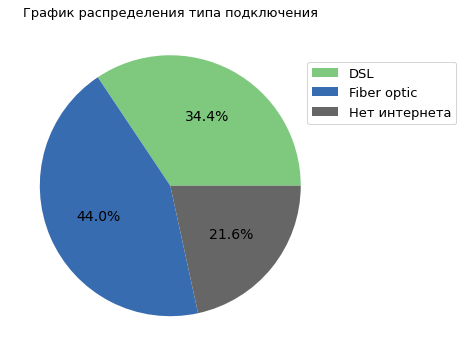

In [53]:
pie_plot(df, 'internet_service', 
        'График распределения типа подключения',
        ['DSL','Fiber optic', 'Нет интернета'])

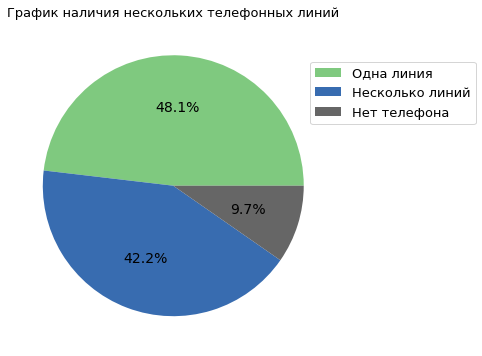

In [54]:
pie_plot(df, 'multiple_lines', 
        'График наличия нескольких телефонных линий',
        ['Одна линия','Несколько линий', 'Нет телефона'])

Интернетом не пользуютя практически в два раза больше клиентов, чем телефоном, следовательно, услуги связанные с телефоном более востребованы.

### Портрет уходящего клиента

In [55]:
out_client = df.loc[df['end_contract']=='1']
in_client = df.loc[df['end_contract']=='0']
out_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 9 to 7023
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         1101 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               1101 non-null   object        
 3   paperless_billing  1101 non-null   object        
 4   payment_method     1101 non-null   object        
 5   monthly_charges    1101 non-null   float64       
 6   total_charges      1101 non-null   float64       
 7   end_contract       1101 non-null   object        
 8   contract_time      1101 non-null   float64       
 9   gender             1101 non-null   object        
 10  senior_citizen     1101 non-null   object        
 11  partner            1101 non-null   object        
 12  dependents         1101 non-null   object        
 13  internet_service   1101 non-null   object        
 14  online_s

In [56]:
# Данные ушедших клиентов
out_client.describe()

,monthly_charges,total_charges,contract_time
count,1101.000000,1101.000000,1101.000000
mean,75.546004,2371.377275,924.863760
std,29.116213,1581.862275,458.771309
min,18.400000,77.840000,28.000000
25%,56.150000,1048.050000,577.000000
50%,84.200000,2139.030000,915.000000
75%,99.500000,3404.910000,1249.000000
max,118.750000,7649.760000,2129.000000


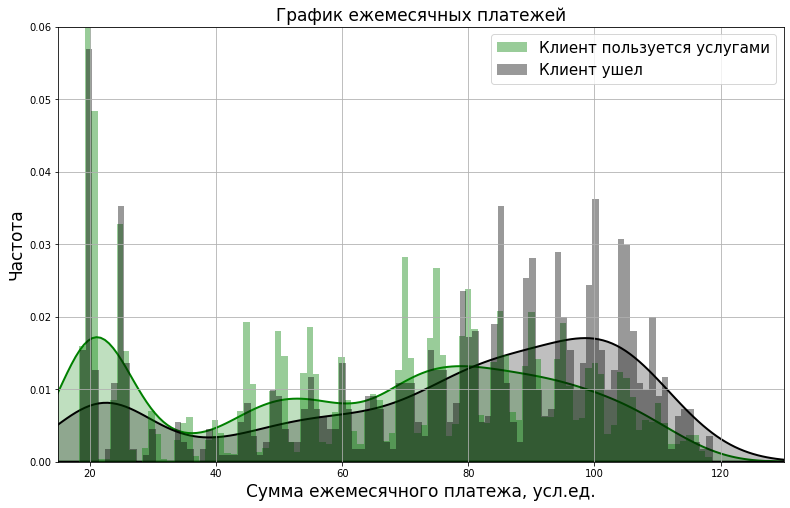

In [57]:
plt.figure(figsize=(13,8))

ax = sns.distplot(in_client['monthly_charges'], hist = True, label='Клиент пользуется услугами', color='green', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

sns.distplot(out_client['monthly_charges'], hist = True, label='Клиент ушел',color='black', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График ежемесячных платежей', fontsize=17)
plt.grid(True)
plt.xlim([15, 130])
plt.ylim([0, 0.06])
plt.legend(fontsize=15)
ax.set_xlabel('Сумма ежемесячного платежа, усл.ед.', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

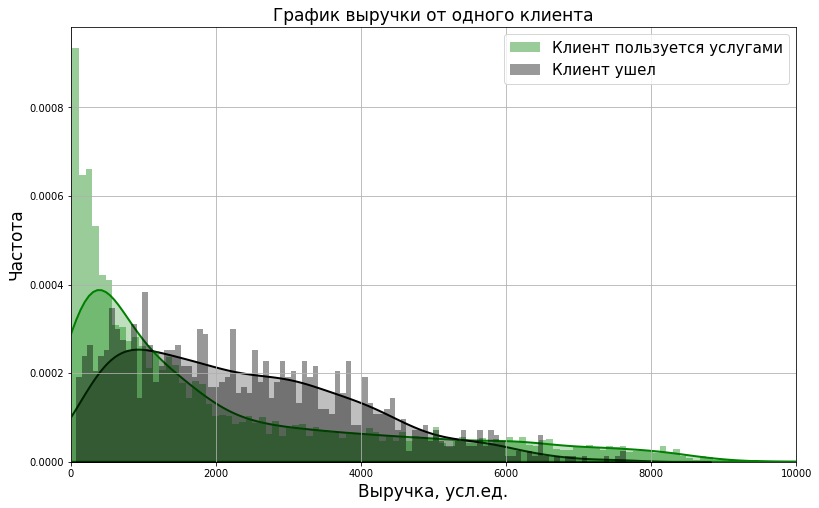

In [58]:
plt.figure(figsize=(13,8))

ax = sns.distplot(in_client['total_charges'], label='Клиент пользуется услугами', color='green', hist = True, bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})
sns.distplot(out_client['total_charges'], label='Клиент ушел', color='black', hist = True, bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График выручки от одного клиента', fontsize=17)
plt.grid(True)
plt.xlim([0, 10000])
plt.legend(fontsize=15)
ax.set_xlabel('Выручка, усл.ед.', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

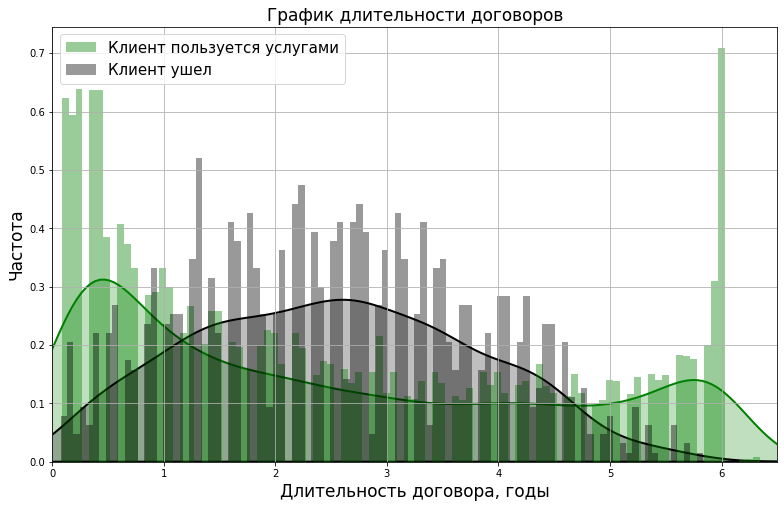

In [59]:
plt.figure(figsize=(13,8))

ax = sns.distplot(in_client['contract_time']/365, hist = True, label='Клиент пользуется услугами', color='green', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})
sns.distplot(out_client['contract_time']/365, hist = True, label='Клиент ушел', color='black', bins=100, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2})

plt.title('График длительности договоров', fontsize=17)
plt.grid(True)
plt.xlim([0, 6.5])
plt.legend(fontsize=15)
ax.set_xlabel('Длительность договора, годы', fontsize=17)
ax.set_ylabel('Частота', fontsize=17)
plt.show()

В отличие от оставшихся клиентов, ушедшие клиенты ежемесячно, и соответственно в течение всего срока действия договора платили больше. Длительность договора для таких клиентов средняя. Возможно, клиенту надоедает оператор или дорогая цена за услуги.

Теперь рассмотрим категориальные признаки для уходящих и остающихся клиентов.

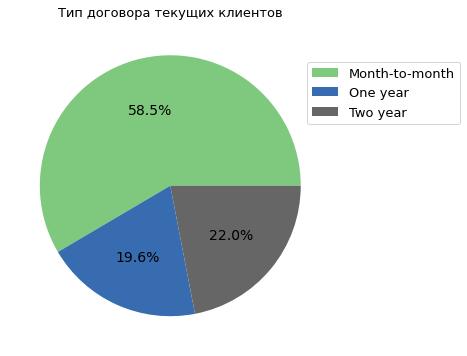

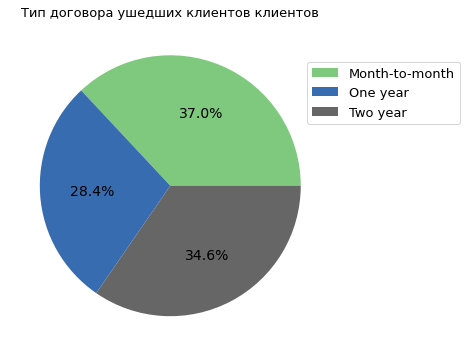

In [60]:
pie_plot(in_client, 'type', 
        'Тип договора текущих клиентов',
        ['Month-to-month', 'One year', 'Two year'])

pie_plot(out_client, 'type', 
        'Тип договора ушедших клиентов клиентов',
        ['Month-to-month', 'One year', 'Two year'])

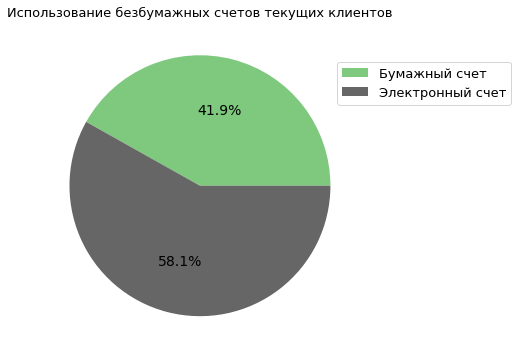

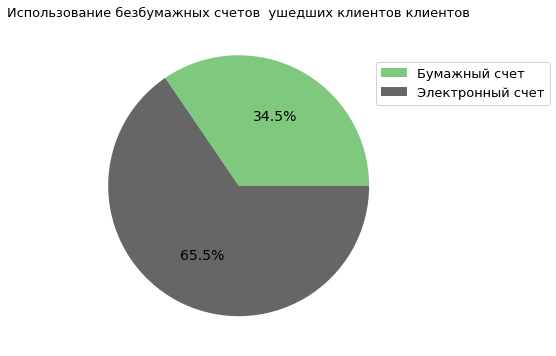

In [61]:
pie_plot(in_client, 'paperless_billing', 
        'Использование безбумажных счетов текущих клиентов',
        ['Бумажный счет','Электронный счет'])

pie_plot(out_client, 'paperless_billing', 
        'Использование безбумажных счетов  ушедших клиентов клиентов',
        ['Бумажный счет','Электронный счет'])

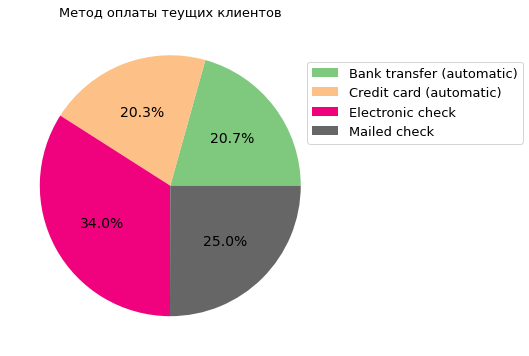

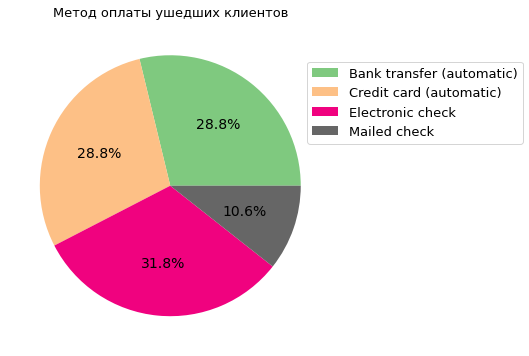

In [62]:
pie_plot(in_client, 'payment_method', 
        'Метод оплаты теущих клиентов',
        ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check',
       'Mailed check'])

pie_plot(out_client, 'payment_method', 
        'Метод оплаты ушедших клиентов',
        ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check',
       'Mailed check'])

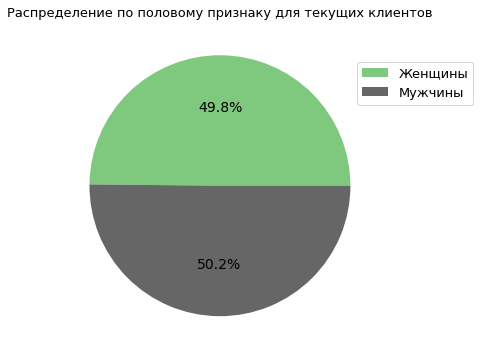

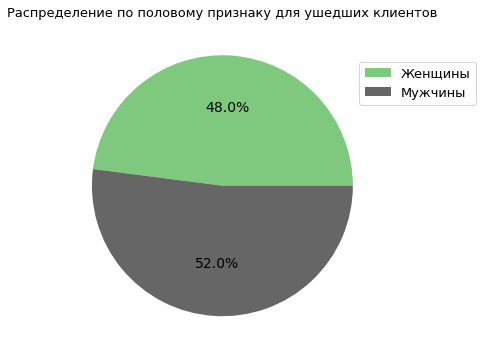

In [63]:
pie_plot(in_client, 'gender', 
        'Распределение по половому признаку для текущих клиентов',
        ['Женщины','Мужчины'])

pie_plot(out_client, 'gender', 
        'Распределение по половому признаку для ушедших клиентов',
        ['Женщины','Мужчины'])

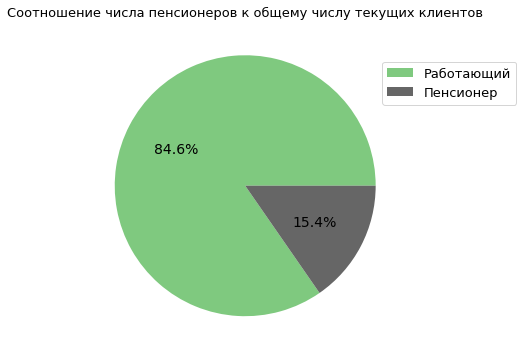

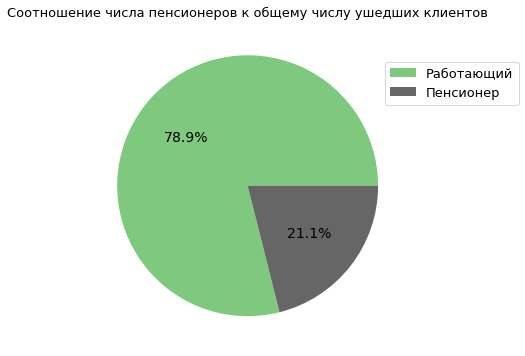

In [64]:
pie_plot(in_client, 'senior_citizen', 
        'Соотношение числа пенсионеров к общему числу текущих клиентов',
        ['Работающий','Пенсионер'])

pie_plot(out_client, 'senior_citizen', 
        'Соотношение числа пенсионеров к общему числу ушедших клиентов',
        ['Работающий','Пенсионер'])

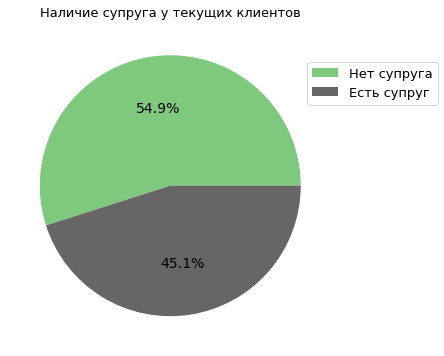

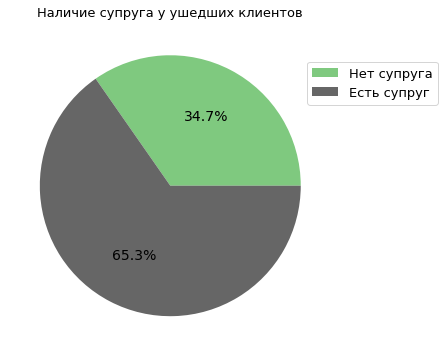

In [65]:
pie_plot(in_client, 'partner', 
        'Наличие супруга у текущих клиентов',
        ['Нет супруга', 'Есть супруг'])

pie_plot(out_client, 'partner', 
        'Наличие супруга у ушедших клиентов',
        ['Нет супруга', 'Есть супруг'])

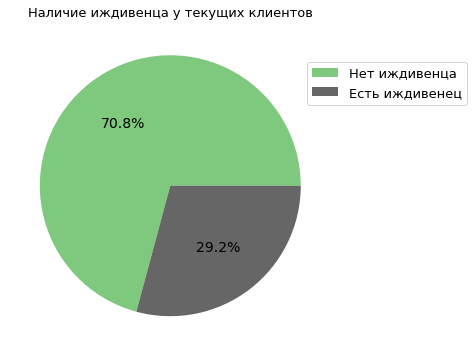

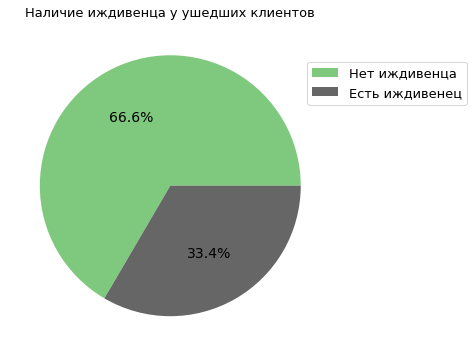

In [66]:
pie_plot(in_client, 'dependents', 
        'Наличие иждивенца у текущих клиентов',
        ['Нет иждивенца','Есть иждивенец'])

pie_plot(out_client, 'dependents', 
        'Наличие иждивенца у ушедших клиентов',
        ['Нет иждивенца','Есть иждивенец'])

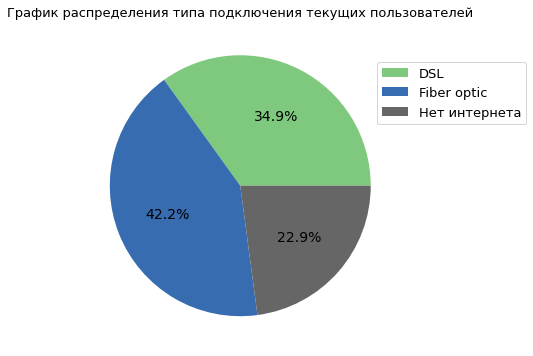

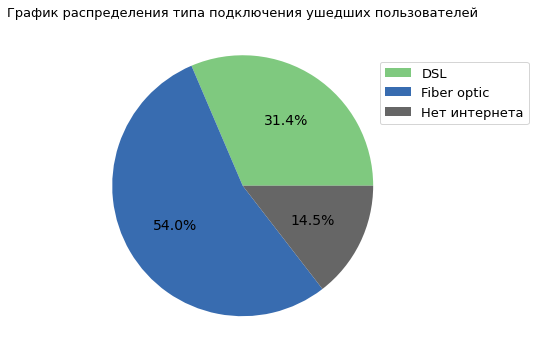

In [67]:
pie_plot(in_client, 'internet_service', 
        'График распределения типа подключения текущих пользователей',
        ['DSL','Fiber optic', 'Нет интернета'])

pie_plot(out_client, 'internet_service', 
        'График распределения типа подключения ушедших пользователей',
        ['DSL','Fiber optic', 'Нет интернета'])

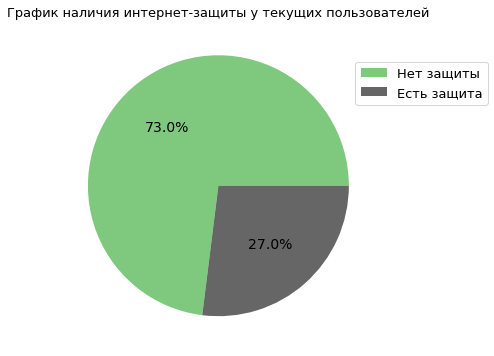

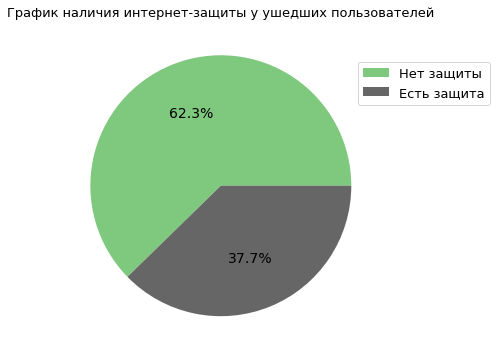

In [68]:
pie_plot(in_client, 'online_security', 
        'График наличия интернет-защиты у текущих пользователей',
        ['Нет защиты','Есть защита'])

pie_plot(out_client, 'online_security', 
        'График наличия интернет-защиты у ушедших пользователей',
        ['Нет защиты','Есть защита'])

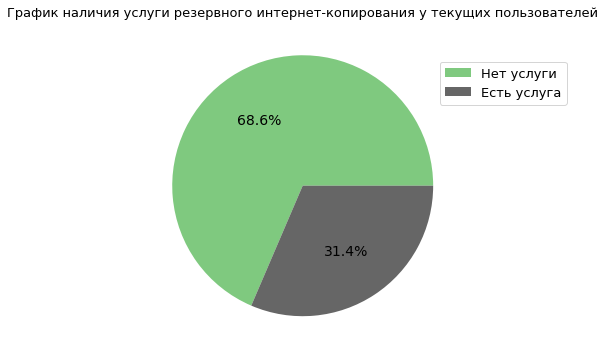

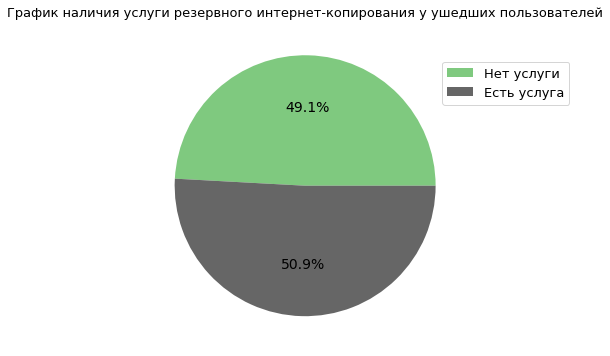

In [69]:
pie_plot(in_client, 'online_backup', 
        'График наличия услуги резервного интернет-копирования у текущих пользователей',
        ['Нет услуги','Есть услуга'])

pie_plot(out_client, 'online_backup', 
        'График наличия услуги резервного интернет-копирования у ушедших пользователей',
        ['Нет услуги','Есть услуга'])

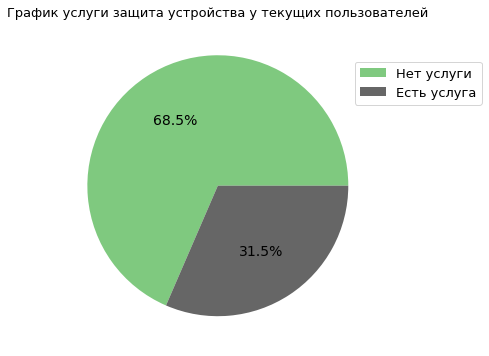

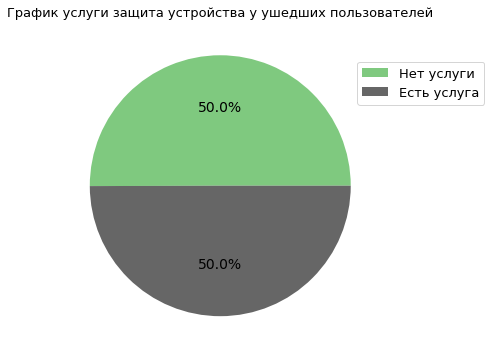

In [70]:
pie_plot(in_client, 'device_protection', 
        'График услуги защита устройства у текущих пользователей',
        ['Нет услуги','Есть услуга'])

pie_plot(out_client, 'device_protection', 
        'График услуги защита устройства у ушедших пользователей',
        ['Нет услуги','Есть услуга'])

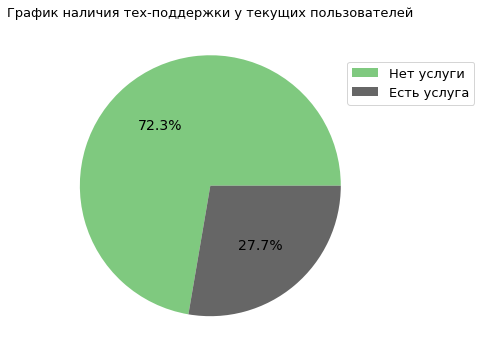

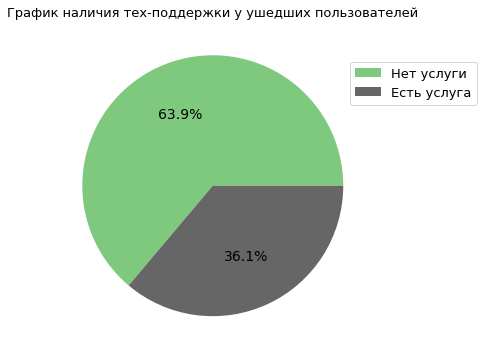

In [71]:
pie_plot(in_client, 'tech_support', 
        'График наличия тех-поддержки у текущих пользователей',
        ['Нет услуги','Есть услуга'])

pie_plot(out_client, 'tech_support', 
        'График наличия тех-поддержки у ушедших пользователей',
        ['Нет услуги','Есть услуга'])

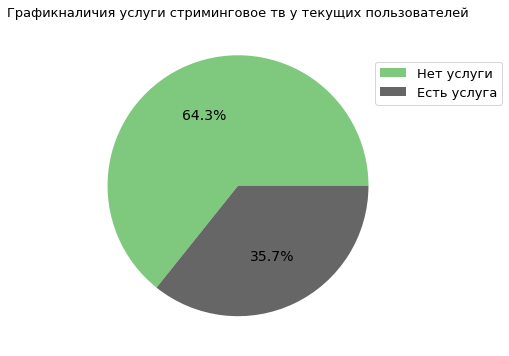

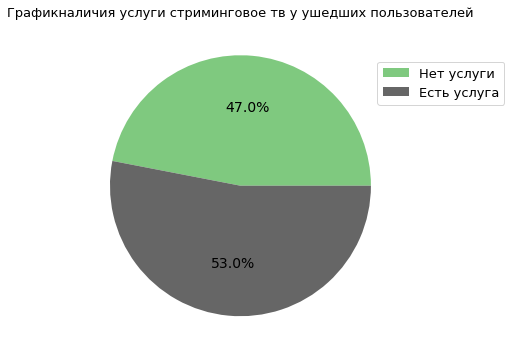

In [72]:
pie_plot(in_client, 'streaming_tv', 
        'Графикналичия услуги стриминговое тв у текущих пользователей',
        ['Нет услуги','Есть услуга'])

pie_plot(out_client, 'streaming_tv', 
        'Графикналичия услуги стриминговое тв у ушедших пользователей',
        ['Нет услуги','Есть услуга'])

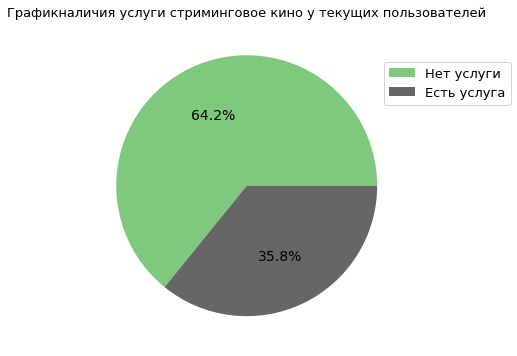

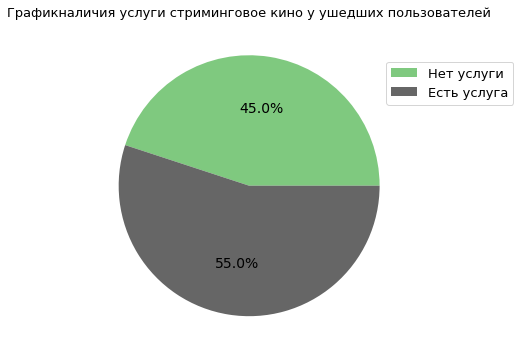

In [73]:
pie_plot(in_client, 'streaming_movies', 
        'Графикналичия услуги стриминговое кино у текущих пользователей',
        ['Нет услуги','Есть услуга'])
pie_plot(out_client, 'streaming_movies', 
        'Графикналичия услуги стриминговое кино у ушедших пользователей',
        ['Нет услуги','Есть услуга'])

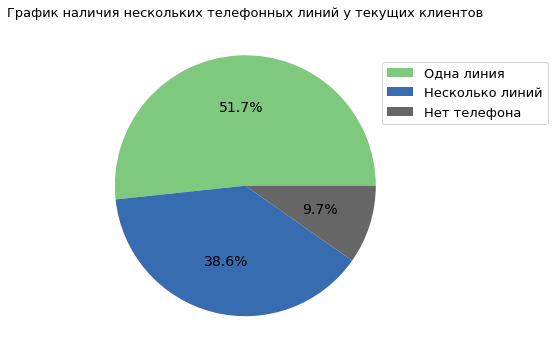

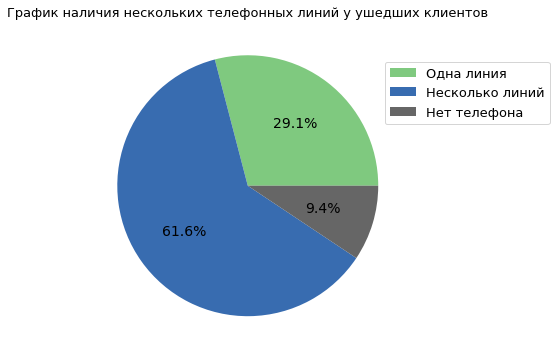

In [74]:
pie_plot(in_client, 'multiple_lines', 
        'График наличия нескольких телефонных линий у текущих клиентов',
        ['Одна линия','Несколько линий', 'Нет телефона'])

pie_plot(out_client, 'multiple_lines', 
        'График наличия нескольких телефонных линий у ушедших клиентов',
        ['Одна линия','Несколько линий', 'Нет телефона'])

По всем вышепредставленным графикам можно обзначить портрет уходящего клиента. Признаки уходящего клинта:
- Высокие ежемесячные платежи и общие затраты;
- Средняя длительность действия договора (2-4 года);
- Такие клиенты как правило пользуются договорами длительного действия (1-2 года);
- Большинство таких клиентов имеют супруга
- Большинсто уходящих клиентов используют тип подключения Fiber optic
- У таких клиентов подключено много услуг (online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies)
- Большинство таких клиентов пользуются несколькими телефонными линиями
- От использования безбумажных счетов, их метода оплаты, пола клиента, является ли клиент пенсионером, наличие иждивенца, портрет уходящего клиента практически не зависит.


### Корреляция признаков

Построим корреляционную матрицу phik для определениялинейных зависимостей между данными.

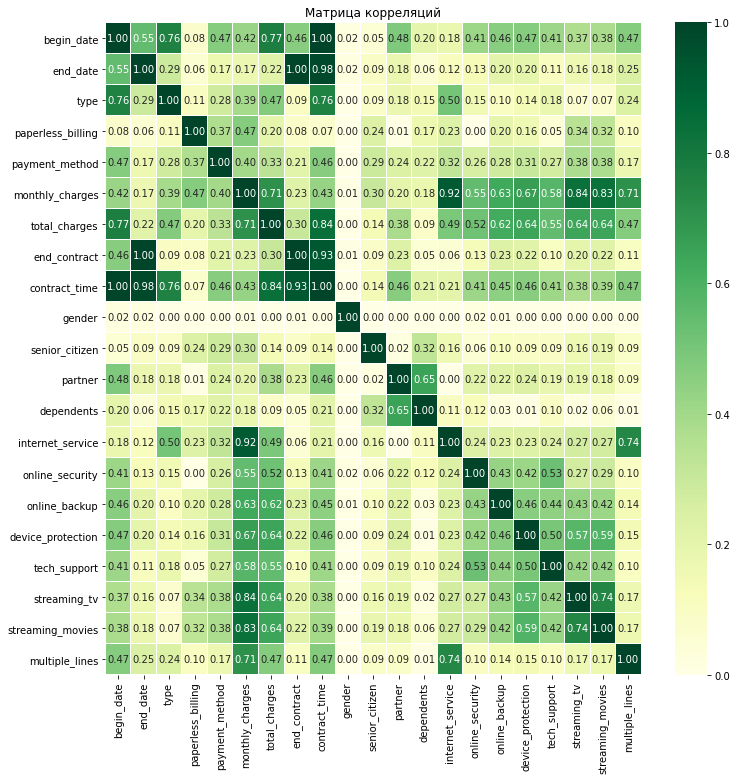

In [75]:
phik_overview = df.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'client_years'])

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(phik_overview, annot=True, fmt='.2f', linewidths=0.01, ax=ax, cmap="YlGn")
plt.title('Матрица корреляций')
plt.show()

Признаки с корреляццией 1 по диагонали коррелируют сами с собой. Признак gender практически не коррелирует с другими признаками. 

Можно заметить, что признак dependents слабо коррелирует почти со всеми признаками, кроме одного признака - partner. Вероятнее всего, в качестве иждивенцев у клиентов значатся дети. 

Также, выделяется взаимосвязь услуг в сфере интернета: можно предположить, что клиенты пользуются несколькими услугами или подключают их пакетом.

Для целевого признака: большое значение корреляции для признака `contract_time`. Признак `gender` практически не коррелирует с целевым признаком - можно удалить.

In [76]:
df.drop(columns=['gender'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7028 non-null   datetime64[ns]
 1   end_date           7028 non-null   datetime64[ns]
 2   type               7028 non-null   object        
 3   paperless_billing  7028 non-null   object        
 4   payment_method     7028 non-null   object        
 5   monthly_charges    7028 non-null   float64       
 6   total_charges      7028 non-null   float64       
 7   end_contract       7028 non-null   object        
 8   contract_time      7028 non-null   float64       
 9   senior_citizen     7028 non-null   object        
 10  partner            7028 non-null   object        
 11  dependents         7028 non-null   object        
 12  internet_service   7028 non-null   object        
 13  online_security    7028 non-null   object        
 14  online_b

Признаки `begin_date` и `end_date` сильно коррелируют с целевым признаком `end_contract` и с признаком `contract_time`. 

Удалим столбцы`begin_date` и `end_date`.

In [77]:
df.drop(columns=['begin_date', 'end_date'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7031
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7028 non-null   object 
 1   paperless_billing  7028 non-null   object 
 2   payment_method     7028 non-null   object 
 3   monthly_charges    7028 non-null   float64
 4   total_charges      7028 non-null   float64
 5   end_contract       7028 non-null   object 
 6   contract_time      7028 non-null   float64
 7   senior_citizen     7028 non-null   object 
 8   partner            7028 non-null   object 
 9   dependents         7028 non-null   object 
 10  internet_service   7028 non-null   object 
 11  online_security    7028 non-null   object 
 12  online_backup      7028 non-null   object 
 13  device_protection  7028 non-null   object 
 14  tech_support       7028 non-null   object 
 15  streaming_tv       7028 non-null   object 
 16  streaming_movies   7028 

Остальные столбцы коррелируют не так сильно и их удаление плохо сказывается на метриках.

### Разделение на выборки

In [78]:
features = df.drop('end_contract', axis=1)
target = df['end_contract']
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                    test_size=0.25,
                                                    random_state=24)
print(features_train.shape)
print(features_test.shape)

(5271, 17)
(1757, 17)


In [79]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()
print(cat_features)


['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [80]:
features_train_ohe = features_train.copy()

In [81]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(features_train_ohe[cat_features])
features_train_ohe[encoder.get_feature_names()
                  ] = encoder.transform(features_train_ohe[cat_features])
features_train_ohe = features_train_ohe.drop(cat_features, axis=1)

scaler = StandardScaler()
features_col_num = ['monthly_charges', 'total_charges', 'contract_time']
features_train_ohe[features_col_num] = scaler.fit_transform(features_train_ohe[features_col_num])

features_train_ohe = features_train_ohe.reset_index(drop=True)
features_train_ohe.head()

,monthly_charges,total_charges,contract_time,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Yes,...,x6_Fiber optic,x6_no_internet,x7_Yes,x8_Yes,x9_Yes,x10_Yes,x11_Yes,x12_Yes,x13_Yes,x13_no_phone
0,1.315625,0.348169,-0.106095,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1,1.270637,0.085003,-0.372406,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.329235,-0.828475,-1.090416,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.720470,-0.829643,-0.955054,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.488909,2.607304,1.506486,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [82]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271 entries, 706 to 4516
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5271 non-null   object 
 1   paperless_billing  5271 non-null   object 
 2   payment_method     5271 non-null   object 
 3   monthly_charges    5271 non-null   float64
 4   total_charges      5271 non-null   float64
 5   contract_time      5271 non-null   float64
 6   senior_citizen     5271 non-null   object 
 7   partner            5271 non-null   object 
 8   dependents         5271 non-null   object 
 9   internet_service   5271 non-null   object 
 10  online_security    5271 non-null   object 
 11  online_backup      5271 non-null   object 
 12  device_protection  5271 non-null   object 
 13  tech_support       5271 non-null   object 
 14  streaming_tv       5271 non-null   object 
 15  streaming_movies   5271 non-null   object 
 16  multiple_lines     527

### Обучение моделей 

#### Логистическая регрессия

In [83]:
%%time

params_log = {'clf__C': [1, 3.5, 4, 4.5, 5, 6, 10],
          'clf__solver': ['lbfgs', 'liblinear'],
          'clf__class_weight' : [None, 'balanced']
         } 

pipe = Pipeline([
    ('clf', LogisticRegression(random_state=240423, 
                               max_iter=500))
])

grid_log = GridSearchCV(pipe, params_log, scoring='roc_auc', n_jobs=-1)
grid_log.fit(features_train_ohe, target_train)

print('Лучшие параметры модели:', grid_log.best_params_)
print('Лучшая метрика roc_auc модели:', grid_log.best_score_)

Лучшие параметры модели: {'clf__C': 5, 'clf__class_weight': None, 'clf__solver': 'lbfgs'}
Лучшая метрика roc_auc модели: 0.7666639511032495
CPU times: user 19.5 s, sys: 49.1 s, total: 1min 8s
Wall time: 1min 8s


In [84]:
log_model = LogisticRegression(random_state=240423, 
                               max_iter=500, C=1,
                               solver='lbfgs',
                               class_weight='None'
                              )
log_model.fit(features_train_ohe, target_train)
print('Accuracy лучшей модели логистической регрессии:', accuracy_score(target_train, log_model.predict(features_train_ohe)))


Accuracy лучшей модели логистической регрессии: 0.8632138114209827


#### Случайный лес

In [85]:
%%time

params_forest = {'clf__max_depth': range(10, 20, 2),
          'clf__min_samples_leaf': range(10, 20, 2),
          'clf__n_estimators': range(400, 500, 50),
          'clf__class_weight' : [None, 'balanced']
         } 

pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=240423))
])
 
grid_forest = GridSearchCV(pipe, params_forest, scoring='roc_auc', n_jobs=-1)
grid_forest.fit(features_train_ohe, target_train)

print('Лучшие параметры модели:', grid_forest.best_params_)
print('Лучшая метрика модели:', grid_forest.best_score_)

Лучшие параметры модели: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 450}
Лучшая метрика модели: 0.8229492679605039
CPU times: user 12min 39s, sys: 0 ns, total: 12min 39s
Wall time: 12min 42s


In [86]:
forest_model = RandomForestClassifier(random_state=240423, 
                               max_depth=10, 
                               min_samples_leaf=14,
                               n_estimators=400,
                               class_weight='balanced'       
                              )
forest_model.fit(features_train_ohe, target_train)
print('Accuracy лучшей модели случайного леса:', accuracy_score(target_train, forest_model.predict(features_train_ohe)))


Accuracy лучшей модели случайного леса: 0.8061088977423638


#### CatBoost (со встроеным кодировщиком)

In [87]:
%%time
params_cat = {'cbc__max_depth': [4, 5, 6],
          'cbc__learning_rate': [0.1, 0.15, 0.2],
          'cbc__n_estimators': [200, 300, 400],
          'cbc__auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
          }

pipe = Pipeline([
    ('cbc',CatBoostClassifier(random_state=240423,
                       cat_features=cat_features,
                       silent=True))
])

grid_cat = GridSearchCV(pipe, params_cat, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_cat.fit(features_train, target_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   1.7s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   2.3s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   1.7s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   1.6s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   1.7s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=300; total time=   2.1s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=300; total time=   2.2s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x7fa0087ab700>)]),
             n_jobs=-1,
             param_grid={'cbc__auto_class_weights': ['None', 'Balanced',
                                                     'SqrtBalanced'],
                         'cbc__learning_rate': [0.1, 0.15, 0.2],
                         'cbc__max_depth': [4, 5, 6],
                         'cbc__n_estimators': [200, 300, 400]},
             scoring='roc_auc', verbose=2)

In [88]:
print('Лучшие параметры модели:', grid_cat.best_params_)
print('Лучшая метрика модели:', grid_cat.best_score_)

Лучшие параметры модели: {'cbc__auto_class_weights': 'None', 'cbc__learning_rate': 0.2, 'cbc__max_depth': 4, 'cbc__n_estimators': 400}
Лучшая метрика модели: 0.909768927975286


In [89]:
cat_model = CatBoostClassifier(random_state=240423, 
                               max_depth=4, 
                               learning_rate=0.2,
                               n_estimators=400,
                               auto_class_weights='None',
                               cat_features=cat_features,
                               silent=True
                              )
cat_model.fit(features_train, target_train)

print('Accuracy лучшей модели CatBoost (со встроеным кодировщиком):', 
      accuracy_score(target_train, cat_model.predict(features_train)))

Accuracy лучшей модели CatBoost (со встроеным кодировщиком): 0.955795864162398


#### CatBoost с использованием get_dummies

In [90]:
features_train_dum = features_train.join(pd.get_dummies(features_train[cat_features], drop_first=True))
features_test_dum = features_test.join(pd.get_dummies(features_test[cat_features], drop_first=True))
features_train_dum.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,contract_time,senior_citizen,partner,dependents,internet_service,...,internet_service_Fiber optic,internet_service_no_internet,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,multiple_lines_no_phone
706,One year,Yes,Bank transfer (automatic),104.65,2853.81,822.0,Yes,No,No,Fiber optic,...,1,0,0,1,0,1,1,1,1,0
4420,Month-to-month,No,Electronic check,103.30,2299.46,641.0,No,Yes,Yes,Fiber optic,...,1,0,0,0,1,1,1,1,1,0
6997,Month-to-month,Yes,Credit card (automatic),75.05,375.25,153.0,Yes,No,No,Fiber optic,...,1,0,0,0,0,0,0,0,1,0
1518,Month-to-month,No,Mailed check,43.55,372.79,245.0,No,No,No,DSL,...,0,0,0,0,0,0,0,0,0,0
1519,Month-to-month,Yes,Credit card (automatic),109.85,7612.60,1918.0,No,No,No,Fiber optic,...,1,0,0,1,1,1,1,1,1,0


In [91]:
%%time
params_cat = {'cbc__max_depth': [4, 5, 6],
          'cbc__learning_rate': [0.1, 0.15, 0.2],
          'cbc__n_estimators': [200, 300, 400],
          'cbc__auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
          }

pipe = Pipeline([
    ('cbc',CatBoostClassifier(random_state=240423,
                       cat_features=cat_features,
                       silent=True))
])

grid_cat = GridSearchCV(pipe, params_cat, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_cat.fit(features_train_dum, target_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   2.0s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   2.0s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   2.2s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   2.1s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=200; total time=   1.9s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=300; total time=   2.8s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth=4, cbc__n_estimators=300; total time=   2.5s
[CV] END cbc__auto_class_weights=None, cbc__learning_rate=0.1, cbc__max_depth

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x7fa0080a48e0>)]),
             n_jobs=-1,
             param_grid={'cbc__auto_class_weights': ['None', 'Balanced',
                                                     'SqrtBalanced'],
                         'cbc__learning_rate': [0.1, 0.15, 0.2],
                         'cbc__max_depth': [4, 5, 6],
                         'cbc__n_estimators': [200, 300, 400]},
             scoring='roc_auc', verbose=2)

In [92]:
print('Лучшие параметры модели:', grid_cat.best_params_)
print('Лучшая метрика модели:', grid_cat.best_score_)

Лучшие параметры модели: {'cbc__auto_class_weights': 'None', 'cbc__learning_rate': 0.2, 'cbc__max_depth': 4, 'cbc__n_estimators': 400}
Лучшая метрика модели: 0.9124474700416055


In [93]:
cat_gd_model = CatBoostClassifier(random_state=240423, 
                               max_depth=4, 
                               learning_rate=0.2,
                               n_estimators=400,
                               auto_class_weights='None',
                               cat_features=cat_features,
                               silent=True
                              )
cat_gd_model.fit(features_train_dum, target_train)

print('Accuracy лучшей модели CatBoost с использованием get_dummies:',
      accuracy_score(target_train, cat_gd_model.predict(features_train_dum)))

Accuracy лучшей модели CatBoost с использованием get_dummies: 0.9538986909504837


### Анализ результатаов

#### Тестирование лучшей модели

In [94]:
models = {'Модель':['Log. Regression', 'Random Forest', 'CatBoost', 'CatBoost get_dummies'],
         'Время обучения':['2 min. 16 s.','10 min. 33 s.','16 min. 51 s.','18 min. 57 s.'],
         'ROC-AUC':['0.78', '0.83', '0.918', '0.916'],
         'Accuacy':['0.86', '0.81', '0.96', '0.96']}

display(pd.DataFrame.from_dict(models))

,Модель,Время обучения,ROC-AUC,Accuacy
0,Log. Regression,2 min. 16 s.,0.78,0.86
1,Random Forest,10 min. 33 s.,0.83,0.81
2,CatBoost,16 min. 51 s.,0.918,0.96
3,CatBoost get_dummies,18 min. 57 s.,0.916,0.96


Лучшее значение метрики ROC-AUC у модели CatBoost со встроеным кодировщиком с параметрами  
- auto_class_weights = 'None', 
- learning_rate = 0.2, 
- depth = 4,
- iterations = 400

Лучшие значения Accuracy у моделей CatBoost(со встроеным кодировщиком) и CatBoost get_dummies (Accuacy: 0.96) - высокие показатели, хороший результат

Исследуем лучшую модель на тестовой выборке.

In [95]:
model_cat = CatBoostClassifier(random_state=240423, verbose=False, depth=4, learning_rate=0.2, 
                               iterations=400, auto_class_weights='None', cat_features=cat_features
                              )
model_cat.fit(features_train, target_train)
prediction = pd.Series(model_cat.predict_proba(features_test)[:,1])
roc_auc = roc_auc_score(target_test, prediction)
print('ROC-AUC лучшей модели:', roc_auc)
print('Accuracy лучшей модели:', accuracy_score(target_test, model_cat.predict(features_test)))

ROC-AUC лучшей модели: 0.9236313956862366
Accuracy лучшей модели: 0.9260102447353443


Показатели хорошие, ROC-AUC >0.85

#### График ROC-кривой

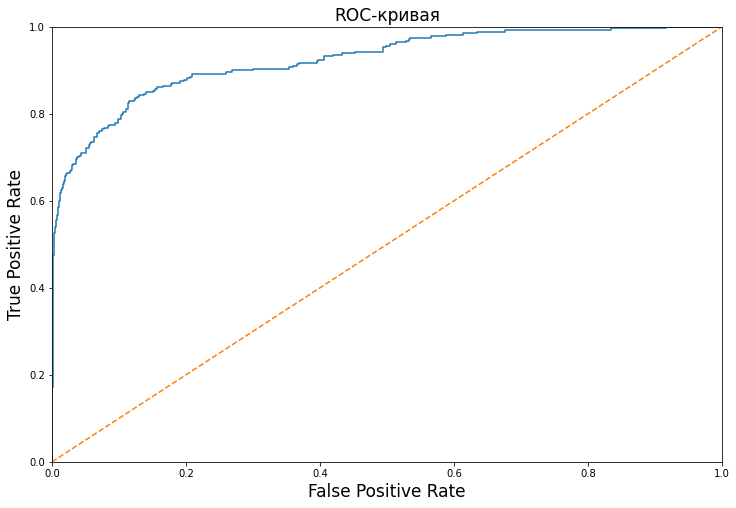

In [96]:
fpr, tpr, thresholds = roc_curve(target_test.astype(int), prediction)

plt.figure(figsize=(12,8))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 17)
plt.ylabel('True Positive Rate', fontsize = 17)
plt.title('ROC-кривая', fontsize = 17)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

ROC-кривая высокая, модель хорошего качества.

#### Распределение важности признаков

In [97]:
pd.DataFrame(model_cat.feature_importances_, index=features_train.dtypes.index, columns=['Важность признаков'])\
                .sort_values(by='Важность признаков', ascending=False).style.bar(color='lightgreen')

,Важность признаков
contract_time,54.623202
total_charges,9.586541
monthly_charges,7.777332
type,7.494123
payment_method,4.091630
multiple_lines,3.449871
partner,3.217926
internet_service,2.261346
online_backup,1.341388
dependents,1.057389


Наибольшее влияние оказывают признаки
- contract_time
- total_charges
- monthly_charges
- type

Наименьшее влияние оказывают признаки, связанные с интернет-услугами.


#### Матрица ошибок

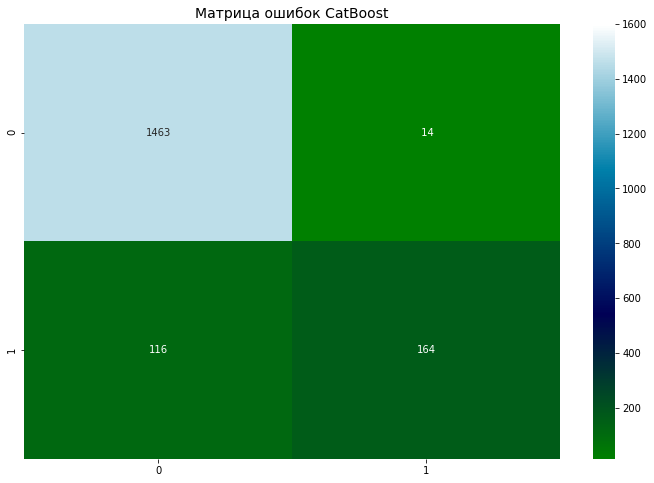

In [98]:
plt.figure(figsize=(12,8))
prediction = model_cat.predict(features_test)
sns.heatmap(confusion_matrix(target_test, prediction),
            annot=True, cmap='ocean', vmax=1600, fmt='3.0f')
    
plt.title('Матрица ошибок CatBoost', fontsize=14)
plt.show()

- True Negative (TN) - левый верхний угол (1469)
- False Positive (FP) -  правый верхний угол (13)
- False Negative (FN) - левый нижний угол (132)
- True Positive (TP) - Правый нижний угол (143)

Из них правильными являются TN и TP (1612), ложными - FN и FP (146). 
Ложноотрицательных ошибок модели достаточно много - почти столько же, сколько истинно положительных ответов. Это значит, что каждый второй клиент, распознанный моделью как уходящий, на самом деле не собирается уходить. Следовательно, скидок моделью будет выдано примерно в 2 раза больше чем было бы необходимо.

#### Вывод

Проанализированы модели

- Log. Regression (ROC-AUC: 0.78)
- Random Forest (ROC-AUC: 0.83)
- CatBoost со встроеным кодировщиком (ROC-AUC: 0.918)
- CatBoost get_dummies (ROC-AUC: 0.916)

Из них лучшая модель - CatBoost со встроеным кодировщиком с параметрами:
    
- auto_class_weights = 'None', 
- learning_rate = 0.2, 
- depth = 4,
- iterations = 400 
         
Исследование лучшей модели на тестовой выборке:
- ROC-AUC: 0.912
- Accuracy: 0.918

Показатели хорошие, ROC-AUC >0.85, высокий поазатель метрики accuracy свидетельствует о качестве модели.

Из распределения важности признаков наибольшее влияние оказывают признаки
- contract_time
- total_charges
- monthly_charges
- type
Наименьшее влияние оказывают признаки, связанные с интернет-услугами.

Исследование матрицы ошибок показало, что ложноотрицательных ошибок модели достаточно много - почти столько же, сколько истинно положительных ответов. Это значит, что каждый второй клиент, распознанный моделью как уходящий, на самом деле не собирается уходить. Следовательно, скидок моделью будет выдано примерно в 2 раза больше чем было бы необходимо.

### Отчет

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Выполненные шаги (согласно плану)
В ходе работы над проектом были проведены следующие шаги:

**Подготовка данных.** Данные загружены и изучены:
- Столбцы переведены к змеиному регистру;
- Изменен тип столбца `total_charges` на float;
- Удалены пропуски в столбце `total_charges` (Пропуски связаны с тем, что оплата у этих клиентов еще не производилась);
- Данные проверены на наличие пропусков и дубликатов (таких данных не оказалось).

**Исследовательский анализ данных**
- Проведено обьединение таблиц по столбцу `customer_id`, после чего этот столбец был удален;
- Добавлен столбец с целеым признаком (факт ухода клиента), где 1 - клиент ушел, 0 - пользуется услугами. Анализ целевого признака показал, что около 1/6 клиентов расторгло контракт (дисбаланс классов);
- Добавлен новый признак - срок действия договора как разность между датой заключения и датой окончания договора (если договор не завершен, в признак был записан срок действия договора на момент выгрузки данных). Анализ срока действия договора показал, что большинство клиентов со сроком действия договора более 5.5 лет продолжают пользоваться услугами оператора;
- Обработаны пропуски, появившиеся при объединении таблиц.
- Проанализированы данные по количеству пользователей интернет-услугами и услугами связи. Интернетом не пользуютя практически в два раза больше клиентов, чем телефоном, следовательно, услуги связанные с телефоном более востребованы;
- Анализ данных показал разнообразие клиентной базы, что хорошо для обучения модели.

В качестве определяющей метрики выбрана AUC-ROC, так как она практически не чувствительа к дисбалансу классов.


Составлен **портрет уходящего клиента.** Признаки уходящего клинта:
- Высокие ежемесячные платежи и общие затраты;
- Средняя длительность действия договора (2-4 года);
- Такие клиенты как правило пользуются договорами длительного действия (1-2 года);
- Большинство таких клиентов имеют супруга;
- Большинсто уходящих клиентов используют тип подключения Fiber optic
- У таких клиентов подключено много услуг (online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies);
- Большинство таких клиентов пользуются несколькими телефонными линиями;
- От использования безбумажных счетов, их метода оплаты, пола клиента, является ли клиент пенсионером, наличие иждивенца, портрет уходящего клиента практически не зависит.

Исследована **корреляция признаков.**
- Удален незначимый признак `gender`;
- Удалены мультиколлинеарные признаки `begin_date` и `end_date`;
- Остальные столбцы коррелируют не так сильно и их удаление плохо сказывается на метриках.

Проведено **разбиение данных на обучающую и тестовую выборку (3/1).** 
Категориальные признаки обучающей выборки закодированы при помощи OneHotEncoder. Численные признаки промасштабированы при помощи StandardScaler.

**Построены и обучены модели** линейной регресси, случайного леса, CatBoost со встроеным кодировщиком и CatBoost с использованием get_dummies. Для поиска нужых гиперпараметров использовался GridSearchCV.

Получены следующие результаты:

In [99]:
models = {'Модель':['Log. Regression', 'Random Forest', 'CatBoost', 'CatBoost get_dummies'],
         'Время обучения':['2 min. 16 s.','10 min. 33 s.','16 min. 51 s.','18 min. 57 s.'],
         'ROC-AUC':['0.78', '0.83', '0.918', '0.916'],
         'Accuacy':['0.86', '0.81', '0.96', '0.96']}

display(pd.DataFrame.from_dict(models))

,Модель,Время обучения,ROC-AUC,Accuacy
0,Log. Regression,2 min. 16 s.,0.78,0.86
1,Random Forest,10 min. 33 s.,0.83,0.81
2,CatBoost,16 min. 51 s.,0.918,0.96
3,CatBoost get_dummies,18 min. 57 s.,0.916,0.96


Лучшее значение метрики ROC-AUC у модели CatBoost со встроеным кодировщиком с параметрами  
- auto_class_weights = 'None', 
- learning_rate = 0.2, 
- depth = 4,
- iterations = 400

**Исследование лучшей модели на тестовой выборке:**
- ROC-AUC: 0.912
- Accuracy: 0.918

Показатели хорошие, ROC-AUC >0.85, высокий поазатель метрики accuracy свидетельствует о качестве модели.

Из **распределения важности признаков** наибольшее влияние оказывают признаки
- contract_time
- total_charges
- monthly_charges
- type
Наименьшее влияние оказывают признаки, связанные с интернет-услугами.

**Исследование матрицы ошибок** показало, что ложноотрицательных ошибок модели достаточно много - почти столько же, сколько истинно положительных ответов. Это значит, что каждый второй клиент, распознанный моделью как уходящий, на самом деле не собирается уходить. Следовательно, скидок моделью будет выдано примерно в 2 раза больше чем было бы необходимо.


#### Трудности

- При попытке поменять тип столбца `total_charges` на float появилась ошибка, свидетельствующая о том, что в данных есть не только числовые признаки. Оказалось, что несколько строк содержат пробелы, означающие, что клиент еще ни разу не оплачивал услуги. Такие строки были удалены, так как их было мало (менее 0.5% от общего числа данных).
- При исследовании мультиколлинеарности были произведены попытки удаления столбцов Total Charges, Internet Services и Streming TV. Однако удаление любого из этих столбцов приводил к значительному ухудшению метрики ROC-AUC. Было принято решение не удалять эти столбцы.

#### Ключевые шаги

- Предобработка данных, чтобы избавиться от пропусков и дубликатов и привести данные к такому виду с которым будет удобно работать;
- Добавление новых признаков (в том числе добавление логистического целевого признака), чтобы улучшить качество моделей и увеличить скорость их обучения;
- Исследовательский анализ данных, чтобы понять структуру клиентской базы, выявить закономерности и на снове этого составить рекомендации заказчику;
- Обучение и анализ моделей, поиск лучшей модели для решения поставленной задачи.

#### Признаки для обучения модели 

- paperless_billing
- payment_method
- monthly_charges
- total_charges
- contract_time
- senior_citizen
- partner
- dependents
- internet_service
- online_security
- online_backup
- device_protection
- tech_support
- streaming_tv
- streaming_movies
- multiple_lines

Категориальные признаки обучающей выборки закодированы при помощи OneHotEncoder. Численные признаки промасштабированы при помощи StandardScaler.


#### Итоговая модель и ее гиперпараметры

Лучшее значение метрики ROC-AUC (0.918) у модели CatBoost со встроеным кодировщиком с параметрами  
- auto_class_weights = 'None', 
- learning_rate = 0.2, 
- depth = 4,
- iterations = 400

**Исследование лучшей модели на тестовой выборке:**
- ROC-AUC: 0.912
- Accuracy: 0.918

Показатели хорошие, ROC-AUC >0.85, высокий поазатель метрики accuracy свидетельствует о качестве модели.